In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### george tutorial

from https://george.readthedocs.io/en/latest/tutorials/first/

In [2]:
import george
george.__version__

'0.4.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,3)

Text(0, 0.5, 'y')

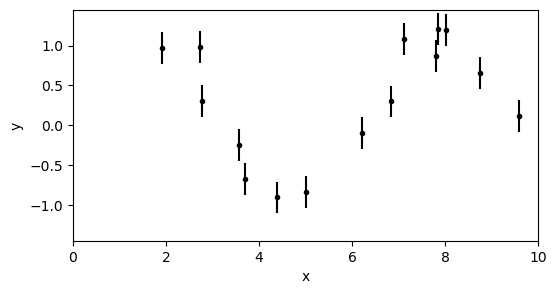

In [4]:
# sinusoidal fake data
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")

In [5]:
# choose a kernel (covariance) function
from george import kernels
kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)

In [6]:
# assume zero mean (default)
gp = george.GP(kernel)

In [7]:
# pre-compute the covariance matrix and factorize it for a set of times and uncertainties
gp.compute(x, yerr)

In [8]:
# predict the function across the full data range
x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

Text(0, 0.5, 'y')

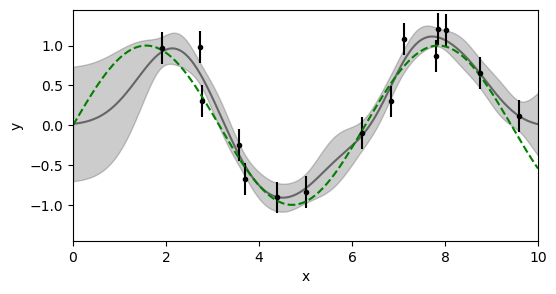

In [9]:
# predicted
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
# original data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# "true" data
plt.plot(x_pred, np.sin(x_pred), "--g")

plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")

The `gp` model provides a handler for computing the marginalized likelihood of the data under this model:

In [10]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -11.82


In [11]:
# fit for the maximum likelihood parameters:
from scipy.optimize import minimize

# (negative) log likelihood of a given parameter vector
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

# (negative) gradient of the log likelihood of a given parameter vector
def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [12]:
# find the parameters that maximize the likelihood function
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.225282556043885
        x: [-4.873e-01  6.041e-01]
      nit: 8
      jac: [-5.070e-06  2.561e-06]
 hess_inv: [[ 5.232e-01  3.004e-01]
            [ 3.004e-01  4.071e-01]]
     nfev: 10
     njev: 10


In [13]:
gp.set_parameter_vector(result.x)
print("Final ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Final ln-likelihood: -9.23


Text(0, 0.5, 'y')

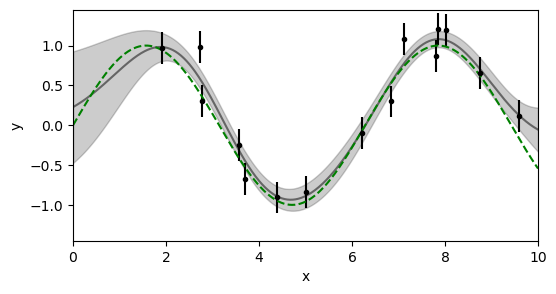

In [14]:
# plot the maximum likelihood model:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")

### repeat, but closer in form to the selection map

In [25]:
npts = 492
x = np.linspace(0, 10, npts)
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

In [26]:
x.shape, y.shape

((492,), (492,))

In [27]:
# scale X -> zero mean
x_scaled = x.copy()
x_scaled -= np.mean(x, axis=0)

In [28]:
# scale y -> log
y_scaled = y.copy()
y_scaled = np.log(y)

/state/partition1/job-33968867/ipykernel_1311398/4137710961.py:3: RuntimeWarning: invalid value encountered in log
  y_scaled = np.log(y)


In [29]:
# scale y err -> log
y_err_scaled = yerr / y

In [30]:
ndim = 1
n_params = 1

In [31]:
# initial parameters
p0 = np.exp(np.full(n_params, 0.1))

In [32]:
# choose a kernel (covariance) function: ExpSquared
kernel = kernels.ExpSquaredKernel(p0, ndim=ndim)

In [33]:
# assume zero mean (default)
gp = george.GP(kernel)

In [34]:
# pre-compute the covariance matrix and factorize it for a set of times and uncertainties
gp.compute(x_scaled, y_err_scaled)